# Environment loading

In [1]:
# ===============================
# Standard Library Imports
# ===============================
import os
from csv import reader as csv_reader

# ===============================
# Third-party Library Imports
# ===============================

# Data Handling
import pandas as pd
from pandas.plotting import register_matplotlib_converters

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import get_cmap
import seaborn as sns

# Numerical/Scientific Computation
import numpy as np
from scipy.optimize import curve_fit
from numpy.fft import fft, ifft
from uncertainties import ufloat, unumpy
from scipy.stats import rankdata

# Geospatial
import geopy.distance

# Machine Learning/Modeling
from sklearn.metrics import r2_score

# Specialized Libraries
from colorspacious import cspace_converter

# Warnings
import warnings

# ===============================
# Notebook and Display Config
# ===============================
from IPython.display import clear_output

# Enable autoreload to automatically reload modules when they change
%load_ext autoreload
%autoreload 2

# ===============================
# Custom Environment Settings
# ===============================
mpl.rcParams['xtick.major.size'] = 12
mpl.rcParams['xtick.major.width'] = 2.3
mpl.rcParams['xtick.minor.size'] = 6
mpl.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['figure.figsize'] = [20, 12]
#plt.rcParams['text.usetex'] = True

# Unicode Translation Maps
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

# ===============================
# Variables
# ===============================
# Define gas types for analysis
gases = ["CH4", "N2", "H2", "O2", "Ar", "CO2", "He", "Kr"]
# Coordinates of site
lavey = (46.20, 7.02)

# ===============================
# Import Custom Functions
# ===============================

from src.functions import *

# ===============================
# Data Import
# ===============================
# Define input data files
data_files = ['data/P201.csv', 'data/P600.csv']
# Process each file into a dictionary of dataframes
dfs_norm = {
    os.path.basename(file).split('.')[0]: process_dataframe(load_csv(file), gases=gases)
    for file in data_files
}
# Import of Earthquakes Data from Seismic Survey Switzerland (ETHZ)
earthquakes = pd.read_csv("data/earthquakes.txt", sep="\t")
## Create a 'DateTime' column and set 'DateTime' as the index
earthquakes.index = pd.to_datetime(earthquakes['year'].apply(str)+' '+ earthquakes['univ_time'])
## Calculate geodesic distances
earthquakes['Distance_llb'] = [geopy.distance.geodesic((lat, lon), lavey).km for lat, lon in zip(earthquakes['latitude'], earthquakes['longitude'])]
# Drop unnecessary columns
earthquakes = earthquakes.drop(["year", "loc_time", "univ_time", "event_type", "assessment", "agency"], axis=1)

# ===============================
# Data Export
# ===============================
output_folder = "figures/"

# Data Preparation

## Data Trimming

[P201] CO2 allowed range: -0.24 to 7.27
[P600] CO2 allowed range: -7.86 to 15.68
[P201] CH4 allowed range: -1.49 to 19.97
[P600] CH4 allowed range: -49.15 to 63.59
[P201] CO2 allowed range: 1.93 to 5.23
[P600] CO2 allowed range: 1.99 to 5.92
[P201] CH4 allowed range: 2.78 to 16.03
[P600] CH4 allowed range: 4.85 to 8.99


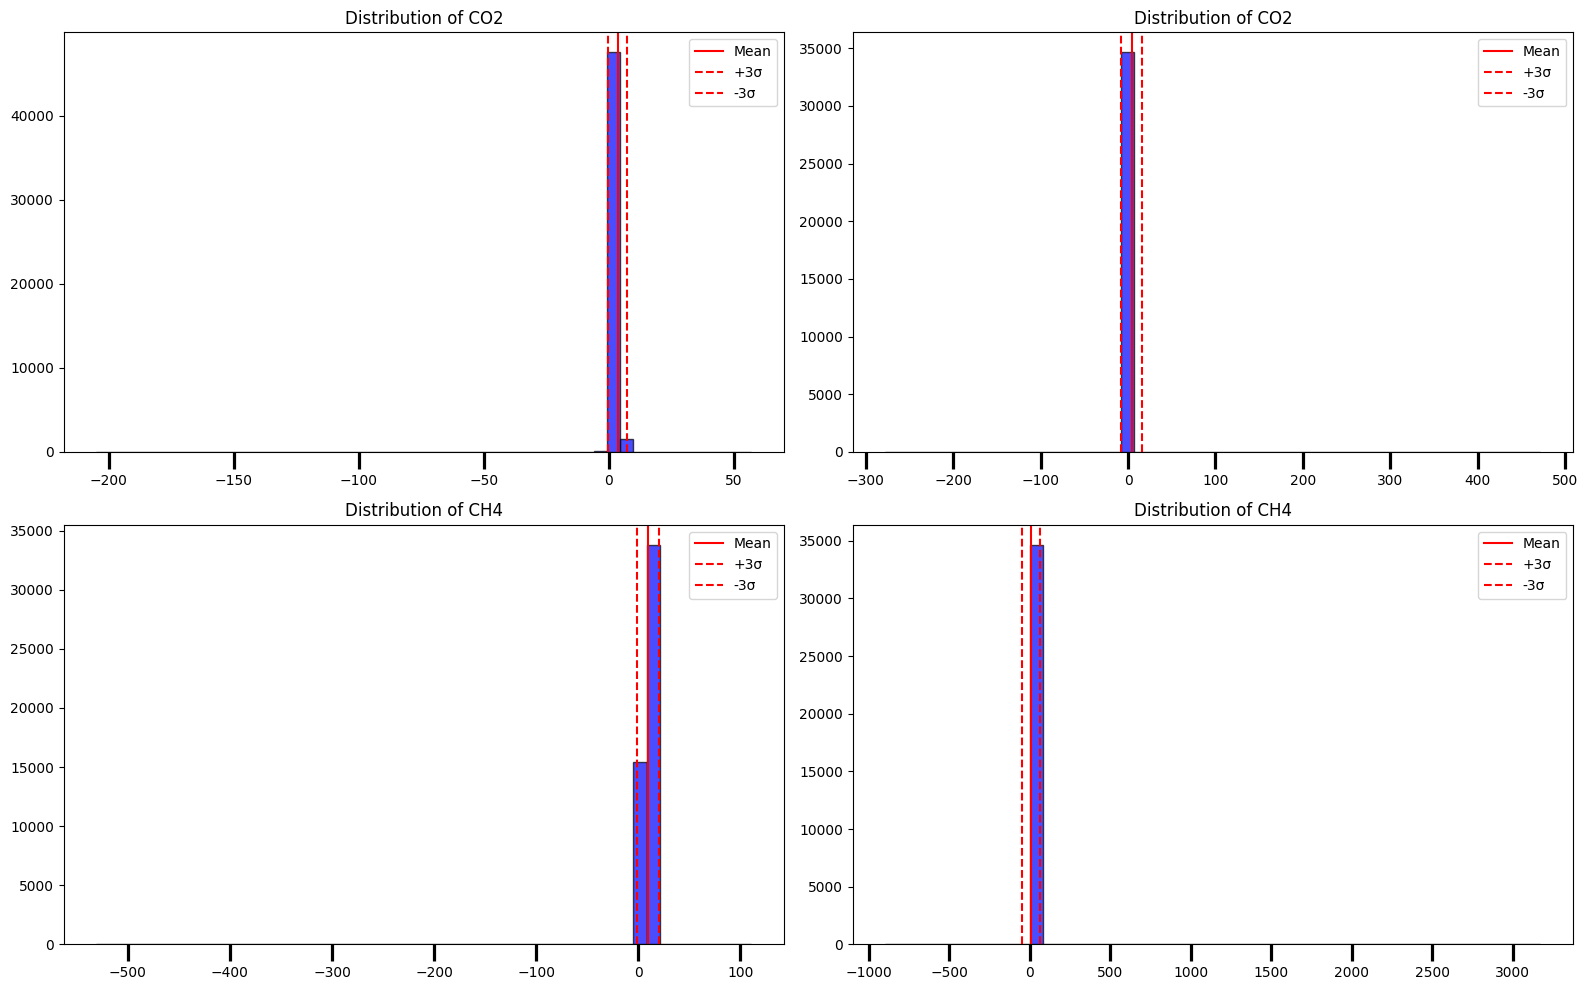

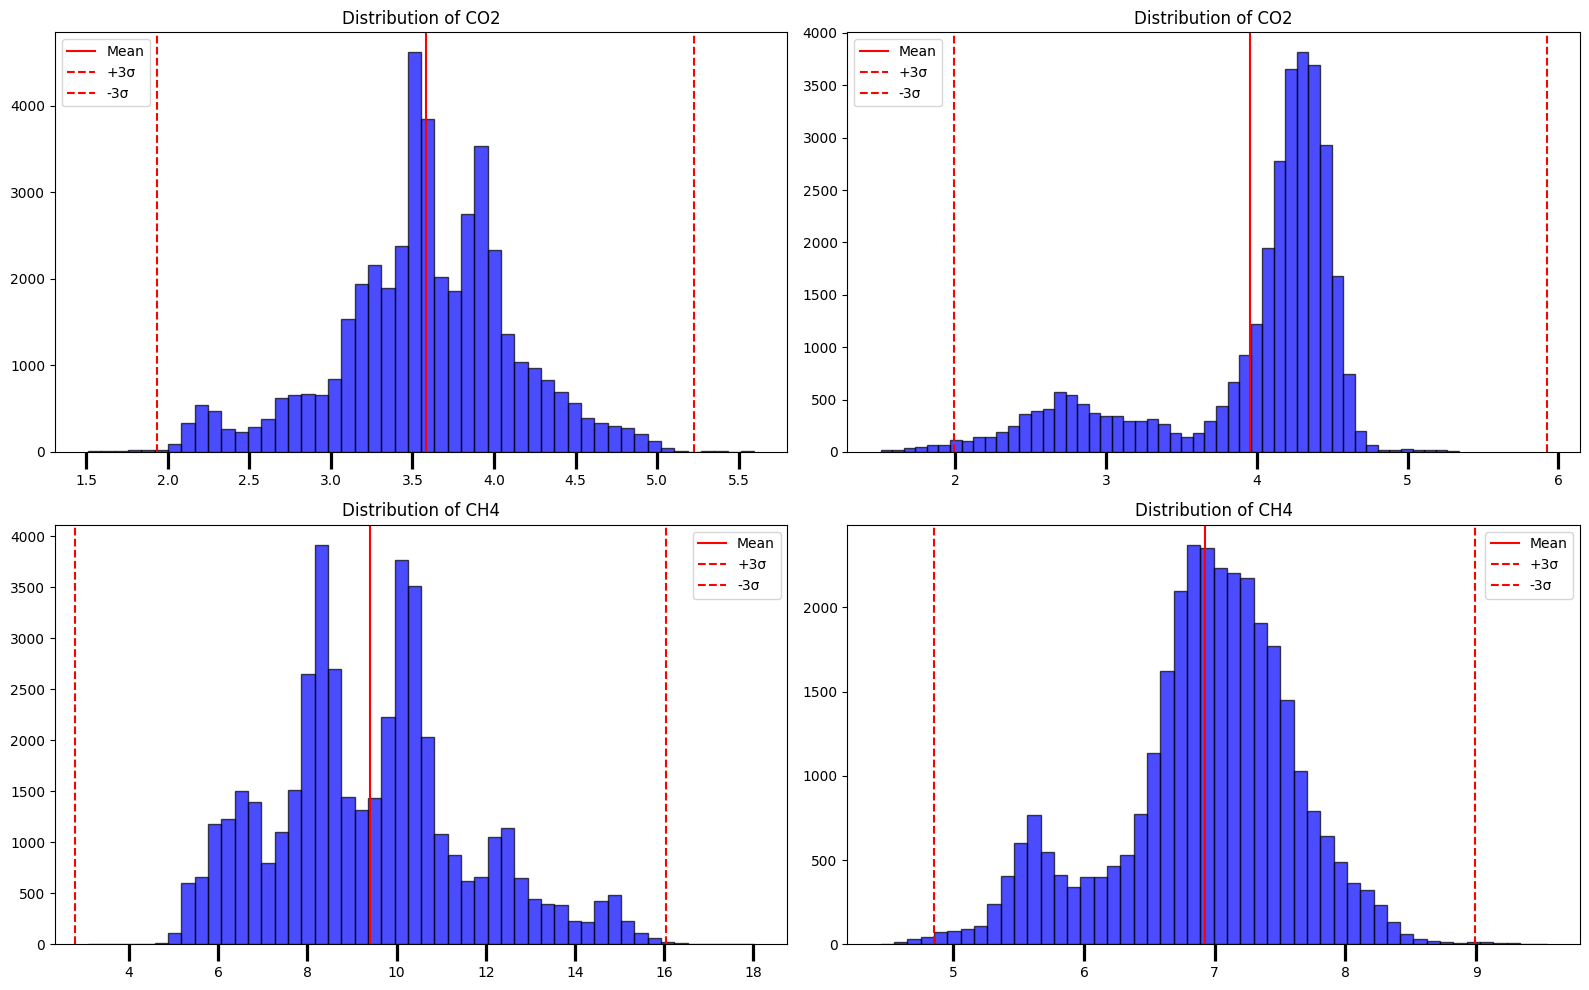

In [2]:
# Set up subplots
fig, axes = setup_subplots()

# List of gas and well combinations to plot
plots = [
    ('P201', 'CO2', axes[0, 0]),
    ('P600', 'CO2', axes[0, 1]),
    ('P201', 'CH4', axes[1, 0]),
    ('P600', 'CH4', axes[1, 1]),
]

# Plot distributions efficiently
for well, gas, subplot in plots:
    df = dfs_norm[well]
    mean, std, lower_limit, upper_limit = compute_limits(df, gas)
    plot_distribution(subplot, df, gas, mean, std, lower_limit, upper_limit)
    print(f"[{well}] {gas} allowed range: {lower_limit:.2f} to {upper_limit:.2f}")

# Adjust layout and show
plt.tight_layout()

# Apply trimming
dfs_norm['P201'] = trim_outliers(dfs_norm['P201'], 'CO2', 1.5, 5.6)
dfs_norm['P600'] = trim_outliers(dfs_norm['P600'], 'CO2', 1.5, 5.6)

# Apply date filtering for dates
# Date Filters
date_filters = {
    "P201": [
        ('2022-06-25', '2022-08-11'),
        ('2024-11-18', '2024-12-02'),
        #('2024-09-01', '2025-04-01')
    ],
    "P600": [
        ('2023-11-01', '2023-11-07'),
        ('2023-12-01', '2023-12-31'),
        ('2024-07-01 12:00:00', '2024-08-01 12:00:00'),
        ('2024-02-01', '2024-02-13'),
        #('2023-10-01', '2024-02-01') #Take a
    ]
}
# Apply date filters
for well, ranges in date_filters.items():
    for start_date, end_date in ranges:
        dfs_norm[well] = date_filter(dfs_norm[well], start_date, end_date)


# Filtering conditions for P201
conditions = [
    {'well': 'P201', 'date_1': '2022-02-01', 'date_2': '2022-04-30', 'gas': 'CH4', 'value': 6.1, 'direction': '<'},
    {'well': 'P201', 'date_1': '2022-07-01', 'date_2': '2022-08-13', 'gas': 'CH4', 'value': 14, 'direction': '>'},
    
    {'well': 'P600', 'date_1': '2023-01-01', 'date_2': '2023-07-31', 'gas': 'CH4', 'value': 8.1, 'direction': '>'},
    {'well': 'P600', 'date_1': '2023-11-01', 'date_2': '2023-12-31', 'gas': 'CH4', 'value': 8.7, 'direction': '>'},
    {'well': 'P600', 'date_1': '2024-01-01', 'date_2': '2024-02-28', 'gas': 'CH4', 'value': 5, 'direction': '<'},
    {'well': 'P600', 'date_1': '2024-04-15', 'date_2': '2024-05-01', 'gas': 'CH4', 'value': 6.6, 'direction': '>'},
    {'well': 'P600', 'date_1': '2024-05-15', 'date_2': '2024-07-31', 'gas': 'CH4', 'value': 7, 'direction': '>'},
    {'well': 'P600', 'date_1': '2024-04-08', 'date_2': '2024-04-11', 'gas': 'CH4', 'value': 6.9, 'direction': '>'},
    {'well': 'P600', 'date_1': '2024-02-01', 'date_2': '2024-02-11', 'gas': 'CH4', 'value': 6.9, 'direction': '>'},
    {'well': 'P600', 'date_1': '2024-04-01', 'date_2': '2024-04-15', 'gas': 'CH4', 'value': 5.0, 'direction': '<'},
]

for cond in conditions:
    remove_rows_by_condition(
        dfs_norm=dfs_norm,
        well=cond['well'],
        date_1=cond['date_1'],
        date_2=cond['date_2'],
        gas=cond['gas'],
        value=cond['value'],
        direction=cond['direction']
    )

# Set up subplots
fig, axes = setup_subplots()

# List of gas and well combinations to plot
plots = [
    ('P201', 'CO2', axes[0, 0]),
    ('P600', 'CO2', axes[0, 1]),
    ('P201', 'CH4', axes[1, 0]),
    ('P600', 'CH4', axes[1, 1]),
]

# Plot distributions efficiently
for well, gas, subplot in plots:
    df = dfs_norm[well]
    mean, std, lower_limit, upper_limit = compute_limits(df, gas)
    plot_distribution(subplot, df, gas, mean, std, lower_limit, upper_limit)
    print(f"[{well}] {gas} allowed range: {lower_limit:.2f} to {upper_limit:.2f}")

# Adjust layout and show
plt.tight_layout()

## Resampling

In [3]:
# Apply the adapted resample function to the dfs_norm dictionary
dfs_norm_h, dfs_norm_d = resample_data_dict(dfs_norm)

# Set the maximum date limit
max_date = pd.to_datetime("2025-01-14")

# Apply the date limit to each DataFrame in the dictionaries
dfs_norm_h = {key: df[df.index <= max_date] for key, df in dfs_norm_h.items()}
dfs_norm_d = {key: df[df.index <= max_date] for key, df in dfs_norm_d.items()}

## Correlation

In [4]:
time_span_201 = (dfs_norm_h['P201'].index > pd.Timestamp('2021-01-01')) & (dfs_norm_h['P201'].index < pd.Timestamp('2023-05-31'))
time_span_600 = (dfs_norm_h['P600'].index > pd.Timestamp('2021-01-01')) & (dfs_norm_h['P600'].index < pd.Timestamp('2023-05-31'))
correlation_matrix_h_P201_short = dfs_norm_h['P201'][time_span_201][['CH4', 'N2', 'H2', 'O2', 'Ar', 'CO2', 'He', 'Kr']].corr()
correlation_matrix_h_P600_short = dfs_norm_h['P600'][time_span_600][['CH4', 'N2', 'H2', 'O2', 'Ar', 'CO2', 'He', 'Kr']].corr()
correlation_matrix_h_P201 = dfs_norm_h['P201'][['CH4', 'N2', 'H2', 'O2', 'Ar', 'CO2', 'He', 'Kr']].corr()
correlation_matrix_h_P600 = dfs_norm_h['P600'][['CH4', 'N2', 'H2', 'O2', 'Ar', 'CO2', 'He', 'Kr']].corr()

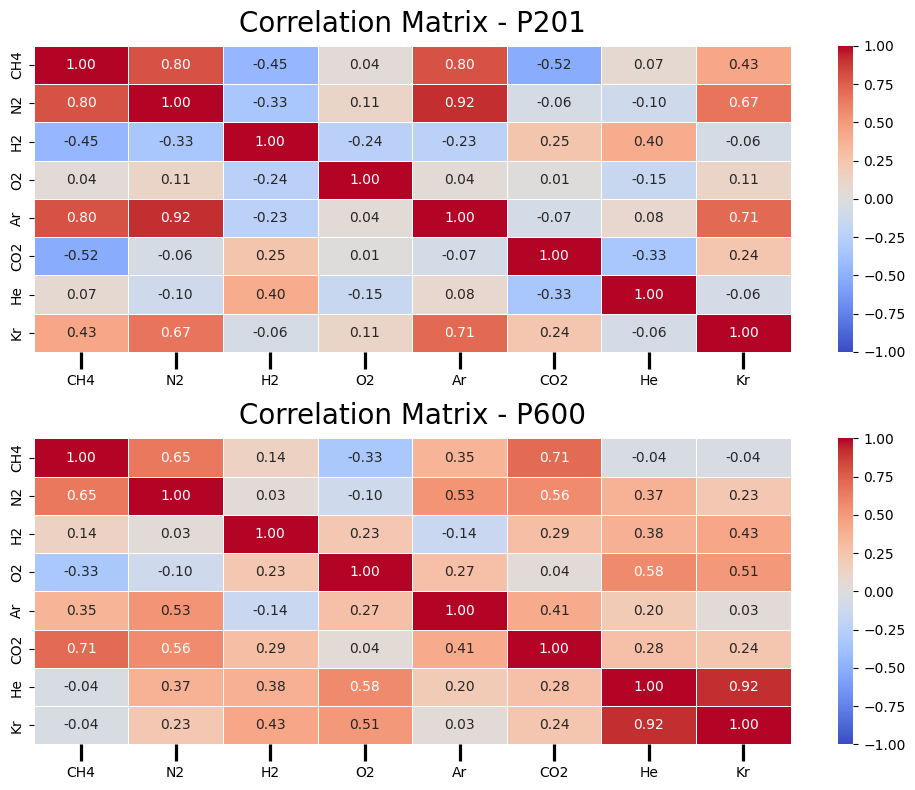

In [5]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Correlation matrix for P201
plt.subplot(2, 1, 1)  # First subplot (for P201)
sns.heatmap(correlation_matrix_h_P201_short, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix - P201', size = 20, pad = 10)

# Correlation matrix for P600
plt.subplot(2, 1, 2)  # Second subplot (for P600)
sns.heatmap(correlation_matrix_h_P600_short, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix - P600', size = 20, pad = 10 )

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("figures/correlation_plot_21_23.pdf", bbox_inches='tight')

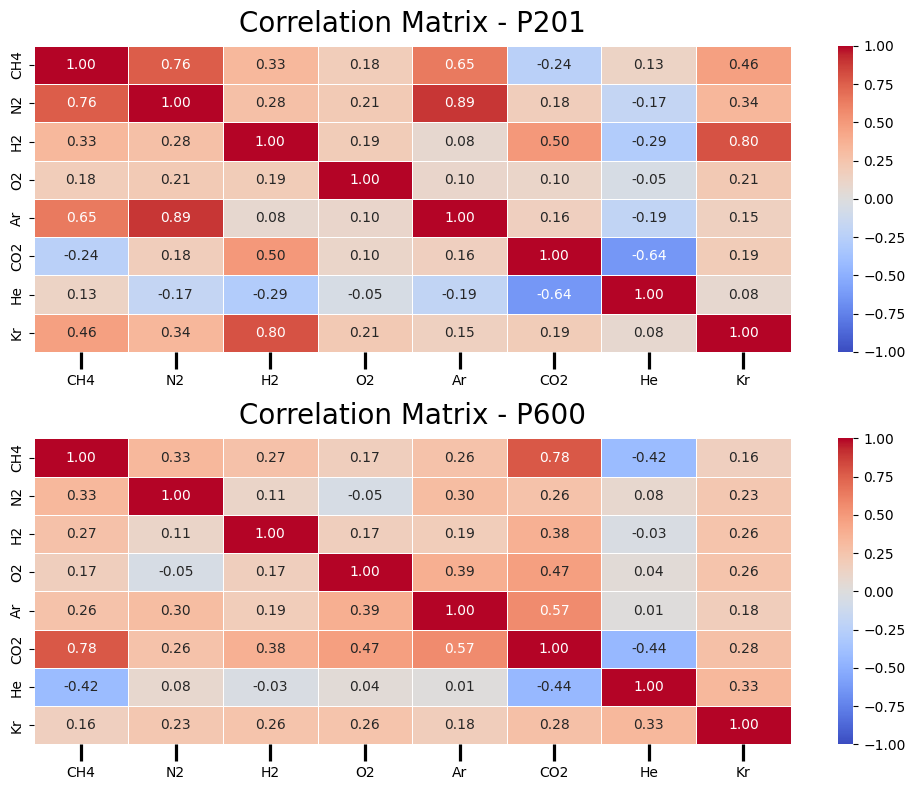

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Correlation matrix for P201
plt.subplot(2, 1, 1)  # First subplot (for P201)
sns.heatmap(correlation_matrix_h_P201, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix - P201', size = 20, pad = 10)

# Correlation matrix for P600
plt.subplot(2, 1, 2)  # Second subplot (for P600)
sns.heatmap(correlation_matrix_h_P600, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix - P600', size = 20, pad = 10 )

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("figures/correlation_plot_21_25.pdf", bbox_inches='tight')

In [6]:
# Functions
def sinusoidal_func(x, a, b, c, d):
    return a * np.sin(b * x + c) + d


def fitter(y):
    # Fit the sinusoidal function to the data
    bounds = ([0, 2*np.pi/365 - 1e-6, -np.inf, -np.inf], [np.inf, 2*np.pi/365 + 1e-6, np.inf, np.inf])
    params, params_covariance = curve_fit(sinusoidal_func, x, y, p0=initial_params, bounds=bounds)

    # Extract the fitted parameters
    a_fit, b_fit, c_fit, d_fit = params

    # Calculate the R-squared value
    y_fit = sinusoidal_func(x, a_fit, b_fit, c_fit, d_fit)
    r_squared = r2_score(y, y_fit)

    # Generate the fitted curve using the fitted parameters
    y_plot = sinusoidal_func(mdates.date2num(x_real), a_fit, b_fit, c_fit, d_fit)

    # Calculate the predicted error
    y_error = y - y_fit
    df_prederror = pd.DataFrame({
        "Fitted_Value": y_fit,
        "Predicted_Error": y_error
    }, index=mdates.num2date(x))
    df_prederror = df_prederror.resample('D').asfreq()

    return df_prederror, y_fit, y_plot, r_squared

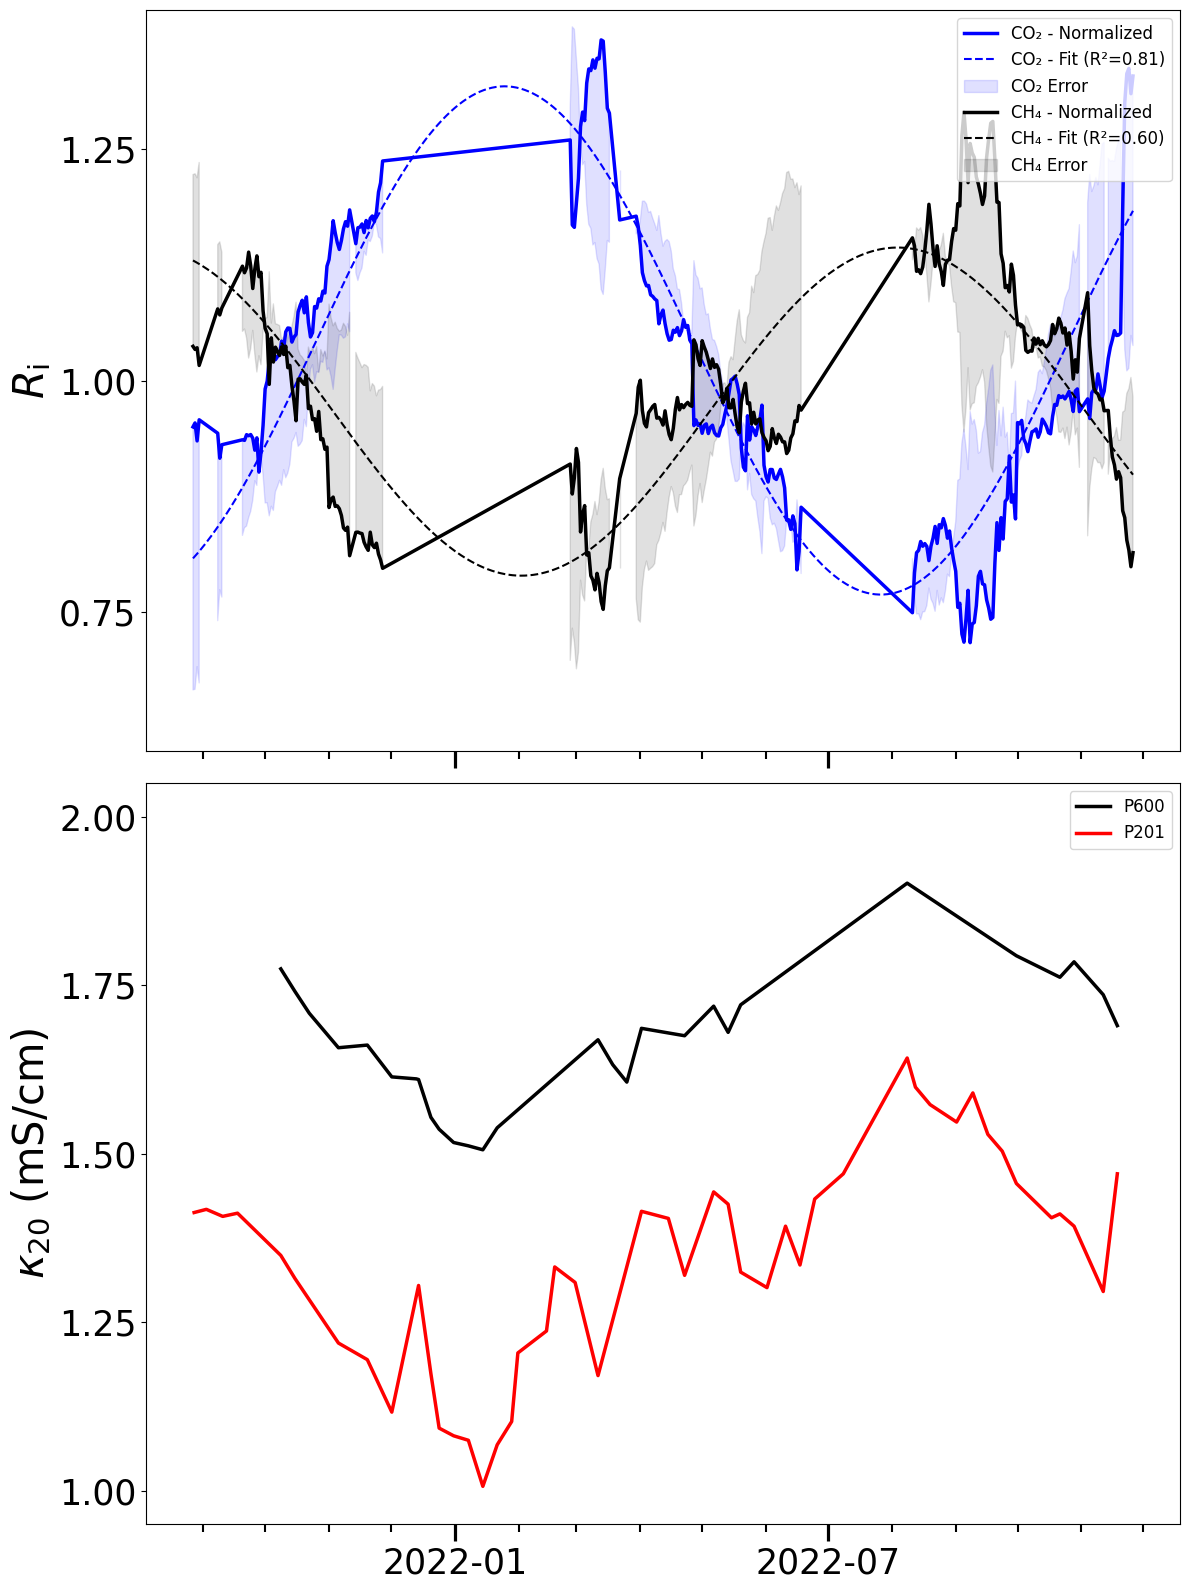

Figure saved to: figures/seasonality_gases_cond.pdf


In [9]:
# === Manually Defined Conductivity Data ===
df_conductivity = pd.DataFrame({
    "Date": pd.to_datetime([
        "2021-08-27 13:25", "2021-09-02 11:45", "2021-09-10 10:00", "2021-09-17 14:45",
        "2021-10-08 14:30", "2021-10-15 10:45", "2021-10-22 10:10", "2021-11-05 13:25",
        "2021-11-19 14:00", "2021-12-01 10:45", "2021-12-13 08:10", "2021-12-14 10:30",
        "2021-12-20 10:00", "2021-12-24 10:00", "2021-12-31 10:45", "2022-01-07 14:00",
        "2022-01-14 14:40", "2022-01-21 13:50", "2022-01-28 14:20", "2022-01-31 14:25",
        "2022-02-14 11:35", "2022-02-18 11:30", "2022-02-28 09:00", "2022-03-11 11:38",
        "2022-03-18 14:40", "2022-03-25 10:58", "2022-04-01 13:30", "2022-04-14 14:30",
        "2022-04-22 11:40", "2022-05-06 13:55", "2022-05-13 14:30", "2022-05-19 16:30",
        "2022-06-01 10:40", "2022-06-10 10:40", "2022-06-17 11:00", "2022-06-24 14:15",
        "2022-07-08 11:20", "2022-08-08 11:00", "2022-08-12 11:00", "2022-08-19 13:30",
        "2022-09-01 10:20", "2022-09-09 07:30", "2022-09-16 14:00", "2022-09-23 13:35",
        "2022-09-30 10:30", "2022-10-17 10:45", "2022-10-21 13:00", "2022-10-28 09:50",
        "2022-11-11 13:30", "2022-11-18 09:30"
    ]),
    "P201": [
        1412.8011, 1417.5466, 1407.1065, 1411.852,
        1349.2114, 1315.0438, None, 1219.1847,
        1194.5081, 1116.6819, None, 1304.6037,
        1173.6279, 1092.9544, 1081.5652, 1074.9215,
        1006.5863, 1068.2168, 1102.7624, 1204.48,
        1237.1064, 1332.1068, 1309.0764, 1170.894,
        None, None, 1414.6324, 1404.0768,
        1319.632, 1443.4204, 1425.188, 1324.43,
        1301.3996, 1392.5616, 1334.9856, 1432.8648,
        1470.2892, 1642.0576, 1598.8756, 1572.9664,
        1547.0572, 1590.2392, 1528.8248, 1503.8752,
        1455.8952, 1405.0364, 1410.794, 1392.5616,
        1295.642, 1470.2892
    ],
    "P600": [
        None, None, None, None,
        1774.3547, 1740.9191, 1708.4669, 1657.3301,
        1661.2637, 1614.0605, 1611.1103, 1610.1269,
        1554.0731, 1536.3719, 1516.7039, 1511.7869,
        1505.8865, 1538.5136, None, None,
        None, None, None, 1669.1468,
        1632.2504, 1606.3232, 1686.0992, None,
        1675.13, 1719.0068, 1680.116, 1721.0012,
        None, None, None, None,
        None, 1901.4944, None, None,
        None, None, None, None,
        1793.7968, None, 1761.8864, 1784.822,
        1735.9592, 1690.088
    ]
})
df_conductivity.set_index("Date", inplace=True)

# === Filter and Normalize Gas Data ===
start_date, end_date = pd.to_datetime("2021-08-25"), pd.to_datetime("2022-11-30")
target_gases = ["CH4", "H2", "O2", "Ar", "CO2", "He", "Kr"]
P201_data = dfs_norm_d['P201'].loc[start_date:end_date]

# Normalize gases by N2 and then by mean
df_cleaned = P201_data[target_gases].dropna().div(P201_data["N2"].dropna(), axis=0)
df_normalized = df_cleaned / df_cleaned.mean()

# === Prepare Time Axes and Fit ===
x = mdates.date2num(df_normalized.index)
x_real = pd.date_range(df_normalized.index[0], df_normalized.index[-1])
initial_params = [1, 2*np.pi/365, np.deg2rad(170), 0]

# Fit CO2 and CH4
df_CO2_err, y_CO2_fit, y_CO2_plot, r2_CO2 = fitter(df_normalized["CO2"].to_numpy())
df_CH4_err, y_CH4_fit, y_CH4_plot, r2_CH4 = fitter(df_normalized["CH4"].to_numpy())

# === Plotting ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16), sharex=True)

# --- Plot Gas Normalization and Fit ---
ax1.plot(df_cleaned.index, df_normalized["CO2"], label="CO₂ - Normalized", color='blue', lw=2.5)
ax1.plot(x_real, y_CO2_plot, '--', label=f"CO₂ - Fit (R²={r2_CO2:.2f})", color='blue')
ax1.fill_between(df_CO2_err.index, 
                 df_CO2_err["Fitted_Value"] + df_CO2_err["Predicted_Error"],
                 df_CO2_err["Fitted_Value"] - df_CO2_err["Predicted_Error"],
                 color='blue', alpha=0.12, label="CO₂ Error")

ax1.plot(df_cleaned.index, df_normalized["CH4"], label="CH₄ - Normalized", color='black', lw=2.5)
ax1.plot(x_real, y_CH4_plot, '--', label=f"CH₄ - Fit (R²={r2_CH4:.2f})", color='black')
ax1.fill_between(df_CH4_err.index, 
                 df_CH4_err["Fitted_Value"] + df_CH4_err["Predicted_Error"],
                 df_CH4_err["Fitted_Value"] - df_CH4_err["Predicted_Error"],
                 color='black', alpha=0.12, label="CH₄ Error")

ax1.set_ylabel(r"$R_{\rm i}$", fontsize=30)
ax1.set_yticks(np.arange(0.5, 1.95, 0.25))
ax1.set_ylim(0.6, 1.4)
ax1.tick_params(labelsize=25)
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
ax1.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# --- Plot Conductivity ---
ax2.plot(df_conductivity["P600"].dropna().index, df_conductivity["P600"].dropna() / 1000, label='P600', color='black', lw=2.5)
ax2.plot(df_conductivity["P201"].dropna().index, df_conductivity["P201"].dropna() / 1000, label='P201', color='red', lw=2.5)
ax2.set_ylabel(r"$κ_{20}$ (mS/cm)", fontsize=30)
ax2.set_yticks(np.arange(0.5, 2.5, 0.25))
ax2.set_ylim(0.95, 2.05)
ax2.tick_params(labelsize=25)

# --- Finalize and Save Plot ---
ax1.legend(loc='upper right', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)
plt.tight_layout()
output_path = os.path.join(output_folder, "seasonality_gases_cond.pdf")
plt.savefig(output_path, bbox_inches='tight')
plt.show()
print(f"Figure saved to: {output_path}")